In [159]:
import shapely
import shapely.wkt
from shapely.geometry import Point, Polygon
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import numpy as np
import json

## Clean the Grid Dataframe

In [160]:
pgh_grid = pd.read_csv('../Data/PGH/pgh_grid.csv')
pgh_grid = pgh_grid.rename(columns={'Unnamed: 0': 'cell_num'})
pgh_grid['tractce10'] = pgh_grid.tractce10.astype(str)

for row,col in pgh_grid.iterrows():
    pgh_grid.at[row, 'geometry'] = shapely.wkt.loads(pgh_grid.loc[row]['geometry'])
    pgh_grid.at[row, 'centroid'] = shapely.wkt.loads(pgh_grid.loc[row]['centroid'])
    tract = pgh_grid.loc[row]['tractce10'].split('.')
    tract = tract[0]
    
    if len(tract) < 6 and tract != 'nan':
        tract = '0' + tract
    
    pgh_grid.at[row, 'tractce10'] = tract

In [161]:
pgh_grid

,cell_num,geometry,centroid,stations,capacity,ids,tractce10
0,0,"POLYGON ((-80.09992749314026 40.3616104190275,...",POINT (-80.09763209887167 40.36390581329607),0,0,set(),nan
1,1,POLYGON ((-80.09992749314026 40.36620120756465...,POINT (-80.09763209887167 40.36849660183323),0,0,set(),nan
2,2,"POLYGON ((-80.09992749314026 40.3707919961018,...",POINT (-80.09763209887167 40.37308739037038),0,0,set(),nan
3,3,POLYGON ((-80.09992749314026 40.37538278463895...,POINT (-80.09763209887167 40.37767817890753),0,0,set(),nan
4,4,"POLYGON ((-80.09992749314026 40.3799735731761,...",POINT (-80.09763209887167 40.38226896744467),0,0,set(),nan
...,...,...,...,...,...,...,...
1659,1659,POLYGON ((-79.86579727774522 40.48556170953056...,POINT (-79.86350188347664 40.48785710379914),0,0,set(),nan
1660,1660,POLYGON ((-79.86579727774522 40.49015249806772...,POINT (-79.86350188347664 40.49244789233629),0,0,set(),nan
1661,1661,POLYGON ((-79.86579727774522 40.49474328660487...,POINT (-79.86350188347664 40.49703868087344),0,0,set(),nan
1662,1662,POLYGON ((-79.86579727774522 40.49933407514202...,POINT (-79.86350188347664 40.50162946941058),0,0,set(),nan


## Clean the Census Dataframes

In [162]:
#fix tract number for PGH
def fixtract(df, column):
    for row, col in df.iterrows():
        #fix census tract number
        tract = df.loc[row][column]
        if len(tract) < 6:
            tract = '0' + tract
        df.at[row, column] = tract
        
    return df

In [163]:
def addpercent_commuting(cm_df):
    cm_df['perc_public'] = cm_df['public_transit'] / cm_df['Workers_16yrs+']
    cm_df['perc_alone'] = cm_df['own_alone'] / cm_df['Workers_16yrs+']
    cm_df['perc_walk'] = cm_df['walked'] / cm_df['Workers_16yrs+']
    cm_df['perc_other'] = cm_df['other'] / cm_df['Workers_16yrs+']
    
    return cm_df

In [164]:
income_df = pd.read_csv('../Data/CensusTractData/income_data_pa.csv')
employment_df = pd.read_csv('../Data/CensusTractData/employment_data_pa.csv')
commuting_df = pd.read_csv('../Data/CensusTractData/commuting_data_pa.csv')

#commuting data
commuting_df['tractce10'] = commuting_df.tractce10.astype(str)
commuting_df = fixtract(commuting_df, 'tractce10')
commuting_df = addpercent_commuting(commuting_df)

#income data
income_df['tractce10'] = income_df.tractce10.astype(str)
income_df = fixtract(income_df, 'tractce10')

for row, col in income_df.iterrows():
    if income_df.loc[row]['mean_hh_income'] == '-' or income_df.loc[row]['mean_hh_income'] == 'N':
        income_df.at[row,'mean_hh_income'] = 0

income_df['mean_hh_income'] = income_df.mean_hh_income.astype(int)

#employment data
employment_df['tractce10'] = employment_df.tractce10.astype(str)
employment_df = fixtract(employment_df, 'tractce10')

In [165]:
pgh_grid.head(1)

,cell_num,geometry,centroid,stations,capacity,ids,tractce10
0,0,"POLYGON ((-80.09992749314026 40.3616104190275,...",POINT (-80.09763209887167 40.36390581329607),0,0,set(),nan


In [166]:
len(pgh_grid)

1664

### Merge Income Dataframe with Grid Dataframe

In [167]:
pgh_grid_income = pgh_grid.merge(income_df, on='tractce10')
len(pgh_grid_income)

728

728 cells out of the 1664 cells centroids are within a census tract. Going to visualize where the cells are located to confirm. It is possible that we are missing at most 2 bike stations due to how the grid cell was created.

In [168]:
geo_cells = gpd.GeoDataFrame(pgh_grid_income, crs='EPSG:2956', geometry=pgh_grid_income['centroid'])

<AxesSubplot:>

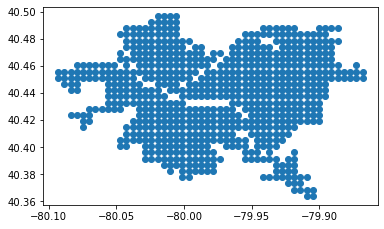

In [169]:
geo_cells.plot()

In [170]:
pgh_grid_inc_emply = pgh_grid_income.merge(employment_df, on='tractce10')
len(pgh_grid_inc_emply)

728

In [171]:
pgh_grid_census = pgh_grid_inc_emply.merge(commuting_df, on='tractce10')
len(pgh_grid_census)

728

In [172]:
pgh_grid_census.columns

Index(['cell_num', 'geometry', 'centroid', 'stations', 'capacity', 'ids',
       'tractce10', 'Unnamed: 0_x', 'total_households', '<$10K', '$10K-15K',
       '$15K-25K', '$25K-35K', '$35K-50K', '$50K-75K', '$75K-100K',
       '$100K-150K', '$150K-200K', '>$200K', 'median_hh_income',
       'mean_hh_income', '13_x', '14_x', '15_x', '16_x', '17', '18', '19',
       '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31',
       '32', '33', '34', '35', '36', '37', '38', '39', '40', '41',
       'med_earnings_male_full-time', 'med_earnings_female_full-time',
       'Unnamed: 0_y', 'population_16yrs+', 'in_labor_force',
       'civ_labor_force', 'employed', 'unemployed', 'armed forces',
       'not_in_labor_force', 'civ_labor_force.1', 'females_16yr+',
       'in_labor_force.1', 'civ_labor_force.2', 'employed.1', '13_y', '14_y',
       '15_y', '16_y', 'Unnamed: 0', 'Workers_16yrs+', 'own_alone', 'carpool',
       'public_transit', 'walked', 'other', 'wfh', 'mean_travel_time_t

In [173]:
pgh_grid_census = pgh_grid_census.drop(columns = ['Unnamed: 0_x', 'capacity', 'Unnamed: 0_y', 'Unnamed: 0', 'geometry', 'centroid'])
pgh_grid_census

,cell_num,stations,ids,tractce10,total_households,<$10K,$10K-15K,$15K-25K,$25K-35K,$35K-50K,...,carpool,public_transit,walked,other,wfh,mean_travel_time_to_work,perc_public,perc_alone,perc_walk,perc_other
0,51,0,set(),563000,1306,59,33,79,76,168,...,226,265,63,0,58,23,0.156342,0.638938,0.037168,0.0
1,52,0,set(),563000,1306,59,33,79,76,168,...,226,265,63,0,58,23,0.156342,0.638938,0.037168,0.0
2,82,0,set(),563000,1306,59,33,79,76,168,...,226,265,63,0,58,23,0.156342,0.638938,0.037168,0.0
3,83,0,set(),563000,1306,59,33,79,76,168,...,226,265,63,0,58,23,0.156342,0.638938,0.037168,0.0
4,84,0,set(),563000,1306,59,33,79,76,168,...,226,265,63,0,58,23,0.156342,0.638938,0.037168,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,1587,0,set(),130600,1391,240,258,161,85,143,...,113,193,0,0,179,26,0.181051,0.545028,0.000000,0.0
724,1588,0,set(),130600,1391,240,258,161,85,143,...,113,193,0,0,179,26,0.181051,0.545028,0.000000,0.0
725,1589,0,set(),130600,1391,240,258,161,85,143,...,113,193,0,0,179,26,0.181051,0.545028,0.000000,0.0
726,1619,0,set(),130600,1391,240,258,161,85,143,...,113,193,0,0,179,26,0.181051,0.545028,0.000000,0.0


## Import Outflow and Inflow

In [174]:
flows = pd.read_csv('../Data/PGH/flows.csv')
flows = flows.drop(columns=['Unnamed: 0'])
flows['tractce10'] = flows.tractce10.astype(str)
flows = fixtract(flows, 'tractce10')
flows.head(4)

,tractce10,outflow,inflow
0,020100,116561,117959
1,010300,4858,4235
2,020300,44073,45411
3,981200,21699,23250


Adding on the ouflow, our y, to the dataset

In [175]:
pgh_grid_census['outflow'] = 0
outflow_dict = dict(zip(flows['tractce10'], flows['outflow']))

for row,col in pgh_grid_census.iterrows():
    if pgh_grid_census.loc[row]['tractce10'] in outflow_dict.keys():
        pgh_grid_census.at[row, 'outflow'] = outflow_dict[pgh_grid_census.loc[row]['tractce10']]

In [176]:
pgh_grid_census

,cell_num,stations,ids,tractce10,total_households,<$10K,$10K-15K,$15K-25K,$25K-35K,$35K-50K,...,public_transit,walked,other,wfh,mean_travel_time_to_work,perc_public,perc_alone,perc_walk,perc_other,outflow
0,51,0,set(),563000,1306,59,33,79,76,168,...,265,63,0,58,23,0.156342,0.638938,0.037168,0.0,0
1,52,0,set(),563000,1306,59,33,79,76,168,...,265,63,0,58,23,0.156342,0.638938,0.037168,0.0,0
2,82,0,set(),563000,1306,59,33,79,76,168,...,265,63,0,58,23,0.156342,0.638938,0.037168,0.0,0
3,83,0,set(),563000,1306,59,33,79,76,168,...,265,63,0,58,23,0.156342,0.638938,0.037168,0.0,0
4,84,0,set(),563000,1306,59,33,79,76,168,...,265,63,0,58,23,0.156342,0.638938,0.037168,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,1587,0,set(),130600,1391,240,258,161,85,143,...,193,0,0,179,26,0.181051,0.545028,0.000000,0.0,0
724,1588,0,set(),130600,1391,240,258,161,85,143,...,193,0,0,179,26,0.181051,0.545028,0.000000,0.0,0
725,1589,0,set(),130600,1391,240,258,161,85,143,...,193,0,0,179,26,0.181051,0.545028,0.000000,0.0,0
726,1619,0,set(),130600,1391,240,258,161,85,143,...,193,0,0,179,26,0.181051,0.545028,0.000000,0.0,0


In [177]:
pgh_grid_census.to_csv('../Data/PGH/DemandPrediction/pgh_grid_census.csv')